# Example Notebook

Loading the package using the command below. 
If you did not install it using pip, make sure the folder 'TGA_utils' is in the same directory as your script. 

In [1]:
import os
import pyTGA as tga
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In its simplest form, the package parses the whole experiment as an instance of the 'TGA_exp' class. To look at the method utilized, you can print it using '.method'. You get the individual stages of the experiment as pandas dataframe using the .stages['stage_name'] method. As a default, all the stages are just labeled 'stage1', 'stage2' etc.

In [18]:
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', 'example_data'))
my_exp = tga.parse_txt(os.path.join(data_dir, 'burnoff_example.txt'), exp_type='general')
print('Date:', my_exp.date)
print('Time:', my_exp.time)
print(my_exp.method)
print(my_exp.stage_names())
print(my_exp.stages['stage2'].head(5))

Date: 26/10/2021
Time: 14:40:00
Method: 
Start the Run 
	Action occurs Immediately 
Switch the Gas to Oxygen at 45.0 ml/min  
	Action occurs Immediately 
1)	Hold for 1.0 min at 30.00°C 
 
2)	Heat from 30.00°C to 800.00°C at 10.00°C/min 
 
3)	Hold for 1.0 min at 800.00°C 
		Switch the Gas to Nitrogen at 45.0 ml/min  
			Action occurs Immediately 
 

['stage1', 'stage2', 'stage3']
       Time  Unsubtracted weight  Baseline weight  Program Temp.  \
0  0.916667             8.795345              0.0           30.0   
1  0.933333             8.795107              0.0           30.0   
2  0.950000             8.794869              0.0           30.0   
3  0.966667             8.794631              0.0           30.0   
4  0.983333             8.794427              0.0           30.0   

   Sample Temp.  Sample Purge Flow  Balance purge flow  
0         30.05               44.9                70.0  
1         30.05               44.9                70.0  
2         30.05               44.9    

For quickly plotting the whole experiment, use the quickplot method.

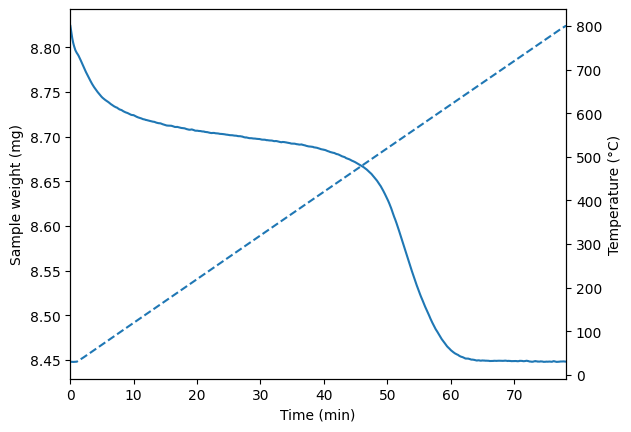

In [3]:
my_exp.quickplot()

Often we only want to use part of a stage, for example if a catalyst looses water. For this we can use the trim_stage method, specifying the temperature range we want to use.

In [4]:
my_exp.trim_stage('stage2',temp_range = [200,750])
print(my_exp.stages['stage2'].head(5))

   index       Time  Unsubtracted weight  Baseline weight  Program Temp.  \
0   1029  18.066667             8.709263              0.0         200.69   
1   1030  18.083333             8.709229              0.0         200.85   
2   1031  18.100000             8.709195              0.0         201.02   
3   1032  18.116667             8.709161              0.0         201.19   
4   1033  18.133333             8.709093              0.0         201.35   

   Sample Temp.  Sample Purge Flow  Balance purge flow  
0        200.05               44.9                70.0  
1        200.21               44.9                70.0  
2        200.37               44.9                70.0  
3        200.54               44.9                70.0  
4        200.71               44.9                70.0  


Often we want to also calculate the derivative of the weighloss profile. We can do this using the calc_DTGA_stage function. with x and y you can specify in waht units to calculate the derivative. As a dafault you can use the temperature and the relative sample weight

In [5]:
my_exp = tga.calc_DTGA_stage(my_exp,'stage2',x='Temp',y='relative')
print(my_exp.stages['stage2'].head(5))

   index       Time  Unsubtracted weight  Baseline weight  Program Temp.  \
0   1029  18.066667             8.709263              0.0         200.69   
1   1030  18.083333             8.709229              0.0         200.85   
2   1031  18.100000             8.709195              0.0         201.02   
3   1032  18.116667             8.709161              0.0         201.19   
4   1033  18.133333             8.709093              0.0         201.35   

   Sample Temp.  Sample Purge Flow  Balance purge flow  DTGA_Temp_relative  
0        200.05               44.9                70.0                 NaN  
1        200.21               44.9                70.0                 NaN  
2        200.37               44.9                70.0                 NaN  
3        200.54               44.9                70.0                 NaN  
4        200.71               44.9                70.0                 NaN  


Now lets plot the profile:

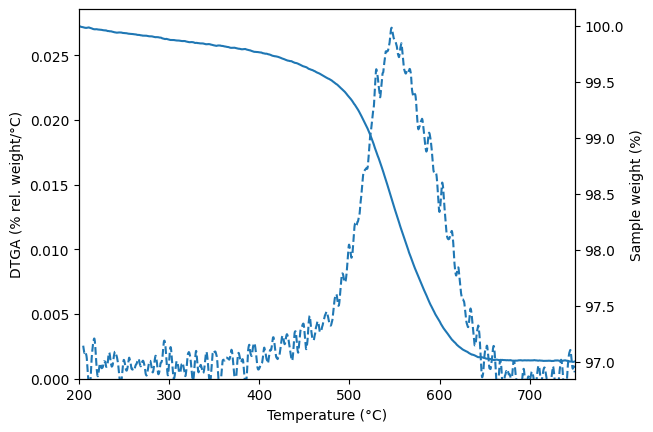

In [6]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
df_TGA = my_exp.stages['stage2']
ax.plot(df_TGA['Sample Temp.'],df_TGA['DTGA_Temp_relative']*100,linestyle='--')
ax2.plot(df_TGA['Sample Temp.'],df_TGA['Unsubtracted weight']/df_TGA['Unsubtracted weight'].max()*100)
ax.set_xlim([200,750])
ax.set_ylim(0,)

ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('DTGA (% rel. weight/°C)')
ax2.set_ylabel('Sample weight (%)')
plt.show()


Now lets determine the coke content by comparing the maximum and minium weight during the experiment:

In [7]:
def get_coke_content(stage):
    catweight = stage['Unsubtracted weight'].min()
    cokeweight = stage['Unsubtracted weight'].max() - catweight
    return cokeweight/(catweight+cokeweight)

coke_content = get_coke_content(my_exp.stages['stage2'])
print('Coke content is',np.round(coke_content*100,3), '%')

Coke content is 3.0 %


And determine the coke burnoff temperature

In [8]:
def calc_Tmax(stage):
    DTGA_cols = [col for col in stage.columns if 'DTGA' in col] #looking for the first DTGA column, in case there are multiple
    Tmax = stage['Sample Temp.'].iloc[stage[DTGA_cols[0]].idxmax()]
    return Tmax

Tmax = calc_Tmax(my_exp.stages['stage2'])
print('Tmax is',Tmax,'°C')

Tmax is 546.83 °C


This is a rather simple experiment. Lets try a more complicated, 2 stage plastic cracking experiment, where we first dry the catalyst, then crack the polymer, and finally burn of the coke. You can see the thermogram for the whole experiment below. Here the important bits are stage 4 where the cracking happens, and stage 8 where the burnoff happens (these are the default values). For these experiments we can make a new subclass 'TGA_pyro', that makes these stages easily accesible and includes calculation of parameters we might use often, e.g. the mass of the catalyst or the T50 temperature. When you want to change which stage is assigned to cracking or burnoff, you can use tga_exp.cracking_stage_name = 'stage2' etc.

Method: 
Start the Run 
	Action occurs Immediately 
Switch the Gas to Nitrogen at 45.0 ml/min  
	Action occurs Immediately 
1)	Hold for 1.0 min at 50.00°C 
 
2)	Heat from 50.00°C to 130.00°C at 5.00°C/min 
 
3)	Hold for 20.0 min at 130.00°C 
 
4)	Heat from 130.00°C to 600.00°C at 5.00°C/min 
 
5)	Hold for 5.0 min at 600.00°C 
 
6)	Cool from 600.00°C to 50.00°C at 500.00°C/min 
 
7)	Hold for 20.0 min at 50.00°C 
 
8)	Heat from 50.00°C to 800.00°C at 20.00°C/min 
		Switch the Gas to Oxygen at 45.0 ml/min  
			Action occurs Immediately 
 
9)	Heat from 800.00°C to 1000.00°C at 100.00°C/min 
 
10)	Hold for 5.0 min at 1000.00°C 
		Switch the Gas to Nitrogen at 45.0 ml/min  
			Action occurs Immediately 
 



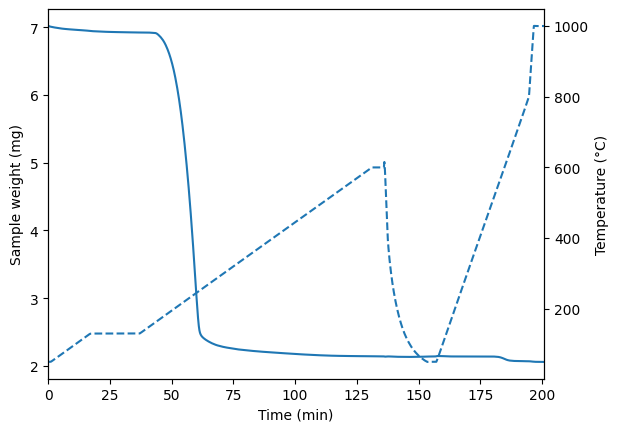

T50 in cracking is 230.89 °C


In [9]:
tga_exp = tga.parse_TGA(data_dir+'/plastic_cracking_example.txt',exp_type='pyro',calculate_DTGA=True)
print(tga_exp.method)
tga_exp.quickplot()
tga_exp.T50 = tga.calc_T50(tga_exp.cracking()) # calculate T50 for the cracking stage
print( 'T50 in cracking is ' + '{} °C'.format(tga_exp.T50))

This allows to access the important stages directly:

In [10]:
print('Pyrolysis part:')
print(tga_exp.cracking().head(5))
print('Burnoff part:')
tga_exp.burnoff().head(5)

Pyrolysis part:
         Time  Unsubtracted weight  Baseline weight  Program Temp.  \
6   37.000000             6.924367              0.0         130.04   
7   37.016667             6.924367              0.0         130.13   
8   37.033333             6.924401              0.0         130.21   
9   37.050000             6.924401              0.0         130.29   
10  37.066667             6.924435              0.0         130.38   

    Sample Temp.  Sample Purge Flow  Balance purge flow  rel_weight_twl  \
6         130.02               44.9                70.0        0.999892   
7         130.04               44.9                70.0        0.999892   
8         130.09               44.9                70.0        0.999897   
9         130.15               44.9                70.0        0.999897   
10        130.22               44.9                70.0        0.999902   

    rel_weight_pwl  DTGA_pwl  DTGA_twl  
6         0.999846       NaN       NaN  
7         0.999846       NaN  

,Time,Unsubtracted weight,Baseline weight,Program Temp.,Sample Temp.,Sample Purge Flow,Balance purge flow,rel_weight_twl,rel_weight_pwl,DTGA_pwl,DTGA_twl
1,157.115641,2.140062,0.0,50.0,50.0,44.9,70.0,0.997924,0.015035,NaN,NaN
2,157.132308,2.140266,0.0,50.0,50.0,44.8,70.0,0.998019,0.015077,NaN,NaN
3,157.148974,2.140436,0.0,50.0,50.0,44.9,70.0,0.998098,0.015112,NaN,NaN
4,157.165641,2.140606,0.0,50.0,50.0,44.9,70.0,0.998177,0.015147,NaN,NaN
5,157.182308,2.140810,0.0,50.0,50.0,44.9,70.0,0.998272,0.015189,NaN,NaN


With methods of the class we can obtain all other paramters of interest. You can make your own subclass and speficy methods for it as required.

In [11]:
results = np.array([tga_exp.m_cat(),tga_exp.m_poly(),tga_exp.coke_yield()])
np.round(results,3,results)
print('Catalyst weight', results[0], 'mg')
print('Polymer weight', results[1], 'mg')
print('Coke yield', results[2]*100, '%')
print('Tmax cracking', tga.calc_Tmax_exp(tga_exp, 'cracking'), '°C')
print('Tmax coke burnoff', tga.calc_Tmax_exp(tga_exp, 'burnoff'), '°C')

Catalyst weight 2.067 mg
Polymer weight 4.858 mg
Coke yield 1.5 %
Tmax cracking 245.0 °C
Tmax coke burnoff 611.05 °C


What if we want to just look at the whole experiment? We can combine all stages using the keyword 'all', or supply it with a list of stages e.g. ['stage1','stage2']

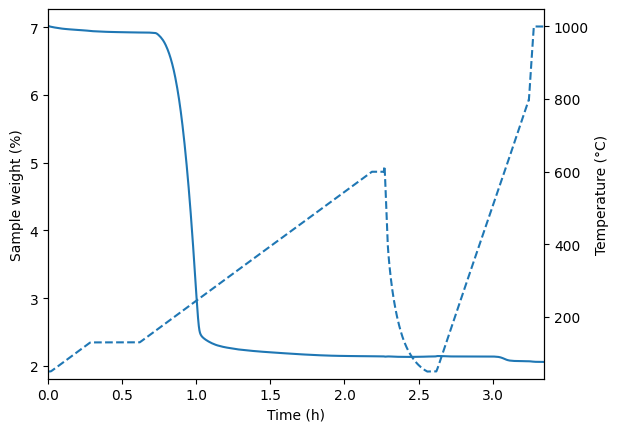

In [12]:
tga_exp.combine_stages('all',new_stage_name='full')
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(tga_exp.stages['full']['Time']/60,tga_exp.stages['full']['Unsubtracted weight'])
ax2.plot(tga_exp.stages['full']['Time']/60,tga_exp.stages['full']['Sample Temp.'],linestyle='--')
ax.set_xlabel('Time (h)')
ax.set_ylabel('Sample weight (%)')
ax2.set_ylabel('Temperature (°C)')
ax.set_xlim(0,tga_exp.stages['full']['Time'].max()/60)
ax2.set_ylim(30,)
plt.show()